## Martin Dionne

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Autocorrelation

'babies.zip` contains baby name frequencies per year (one file per year). You can treat each baby name as a time series.

1. Get the autocorrelation and partial autocorrelation for the names `Olivia`, `Newton` and `John`.

2. Which name do you expect to be the most popular in 2022? Use an ARIMA model and backtesting to pick 3 interesting candidates. Support your findings with a plot

In [2]:
from zipfile import ZipFile

df = pd.DataFrame()
colnames = ['name', 'gender', 'count']

# Read the zip file
with ZipFile("data/babies.zip") as temp_zip:
    for file_name in temp_zip.namelist():
        if ".txt" in file_name:
            # Read the current file from the zip
            with temp_zip.open(file_name) as temp_file:
                temp_df = pd.read_csv(temp_file, names=colnames)
                temp_df['year'] = file_name[3:7]
                df = pd.concat([df, temp_df])

df.to_csv('data/baby_names.csv', index=False)
df

,name,gender,count,year
0,Mary,F,9217,1884
1,Anna,F,3860,1884
2,Emma,F,2587,1884
3,Elizabeth,F,2549,1884
4,Minnie,F,2243,1884
...,...,...,...,...
2079,Titus,M,5,1883
2080,Toney,M,5,1883
2081,Verna,M,5,1883
2082,Winnie,M,5,1883


In [3]:
df = pd.read_csv('data/baby_names.csv')

In [4]:
def get_name(df, name, gender, diff=True):
    sub = df.loc[df['name'] == name]
    sub = sub.loc[df['gender'] == gender]
    sub['year'] = pd.to_datetime(sub['year'], format='%Y')
    sub = sub.set_index('year').sort_index()
    if diff:
        sub = (sub['count'] - sub['count'].shift())[1:]
    return sub

olivia = get_name(df, 'Olivia', 'F')
newton = get_name(df, 'Newton', 'M')
john = get_name(df, 'John', 'M')

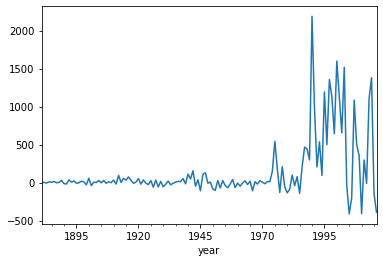

In [5]:
# difference Olivia plot
olivia.plot();
#newton.plot();
#john.plot();

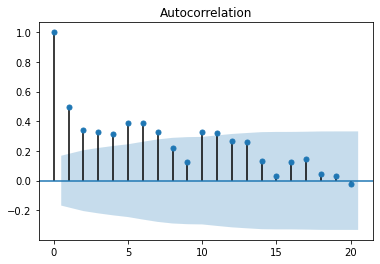

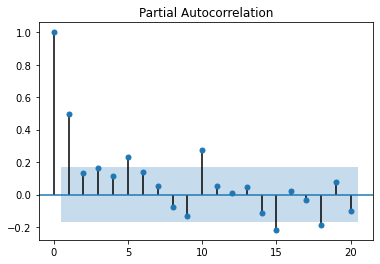

In [6]:
# 1. Get the autocorrelation and partial autocorrelation for the names Olivia, Newton and John.
plot_acf(olivia, lags=20);
plot_pacf(olivia, lags=20);

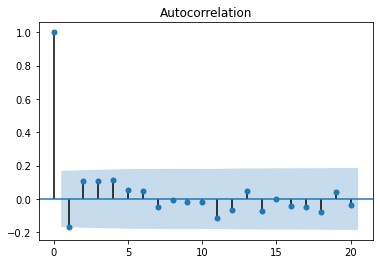

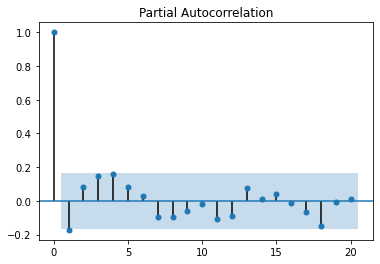

In [7]:
plot_acf(newton, lags=20);
plot_pacf(newton, lags=20);

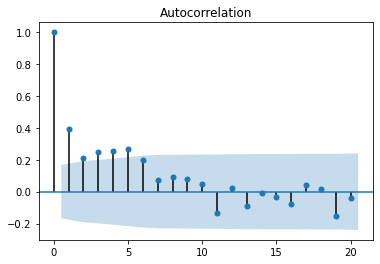

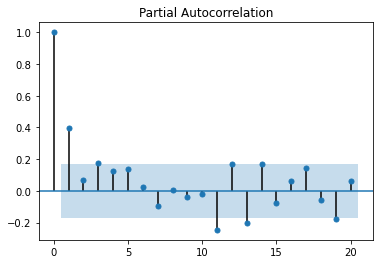

In [8]:
plot_acf(john, lags=20);
plot_pacf(john, lags=20);

In [9]:
# Choose AR (p) based on Autocorrelations and MA (q) based on Partial Autocorrelations and I (d) is differenciation (0 or 1)
# across the 3 samples (names), lags 1 and 2 explain most of it

In [10]:
# 2. Which name do you expect to be the most popular in 2022? (ARIMA + Backtesting)

# get top names for the last 2 years
sub = df.loc[df['year'] > 2014]
name_list = sub.groupby(by=['name','gender'])['count'].sum()
name_list = name_list.sort_values(ascending=False)
name_list = name_list[:10].index
name_list

MultiIndex([(    'Emma', 'F'),
            (  'Olivia', 'F'),
            (    'Noah', 'M'),
            (    'Liam', 'M'),
            (  'Sophia', 'F'),
            (     'Ava', 'F'),
            (   'Mason', 'M'),
            ( 'William', 'M'),
            (   'Jacob', 'M'),
            ('Isabella', 'F')],
           names=['name', 'gender'])

In [11]:
def predict_name_count(df, name, gender, plot=True):
    sub = df.loc[df['year'] > 1990]
    sub = sub.loc[df['name'] == name]
    sub = sub.loc[df['gender'] == gender]
    sub['year'] = pd.to_datetime(sub['year'], format='%Y')
    sub = sub.set_index('year').sort_index()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = ARIMA(sub['count'], order=(2, 1, 0))  
        res = model.fit(disp=-1)
        pred = round(res.forecast(2022-2016)[0][-1])

    if plot: 
        fig, ax = plt.subplots()
        ax.plot(sub['count'])
        res.plot_predict('2016', '2022', ax=ax);
    return (name, pred)

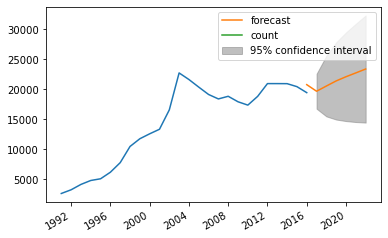

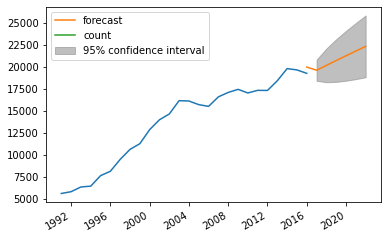

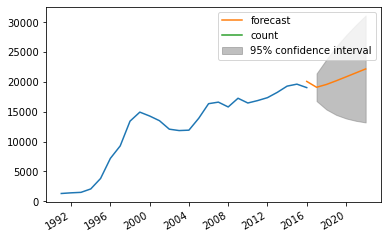

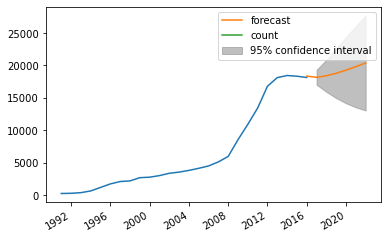

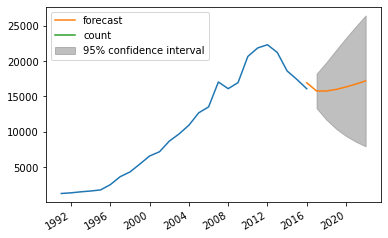

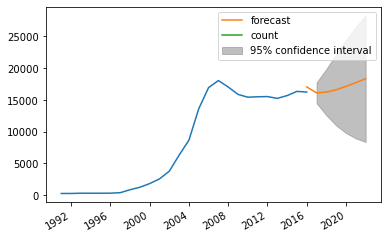

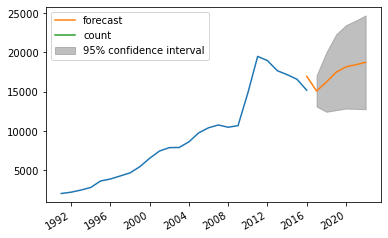

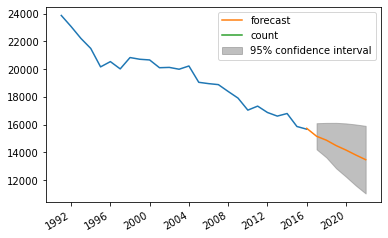

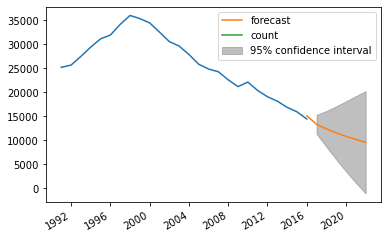

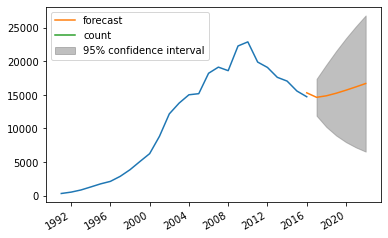

In [12]:
pred_2020 = []
for n in range(len(name_list)):
    pred_2020.append(predict_name_count(df, name_list[n][0], name_list[n][1]))

In [13]:
pred_2020

[('Emma', 23355),
 ('Olivia', 22314),
 ('Noah', 22137),
 ('Liam', 20371),
 ('Sophia', 17179),
 ('Ava', 18335),
 ('Mason', 18747),
 ('William', 13473),
 ('Jacob', 9556),
 ('Isabella', 16693)]

# 2. Counterfactual prediction testing

The [FRED](https://fred.stlouisfed.org) database has economic data useful for this question.

A common method to test the effect of a one-off event is to fit an ARIMA model up to the event, and compare the forecast to the actual data of what happened, then measure the gap between the forecast and the event data.

1. Use GDP and unemployment data with the Counterfactual prediction testing methodology to get an estimate of the magnitude of COVID (around March 2020 as a cutoff date) on these two statistics. Use an ARIMA model which fits best to the pre-COVID time series and compare the output of both. Provide a visualization.

2. Is GDP a unit root process or trend stationary? Use the 2008 and 2020 GDP shocks and statistical tests we've seen in class to provide an argument (it's possible event one says one thing and the other event says the opposite).

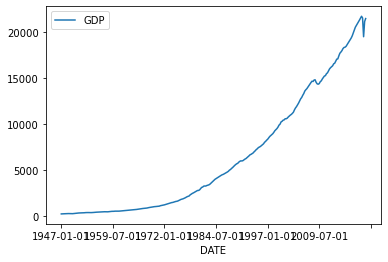

In [14]:
gdp = pd.read_csv('data/GDP.csv', index_col='DATE')
gdp.plot();

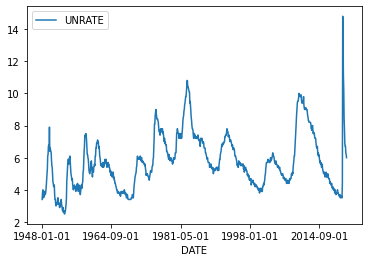

In [15]:
un = pd.read_csv('data/UNRATE.csv', index_col='DATE')
un.plot();

In [16]:
# 1. Use GDP and unemployment data with the Counterfactual prediction testing methodology

In [17]:
def arima_gridsearch(df, p=5, d=1, q=5):
    results = []
    for i in range(p+1): 
        for j in range(d+1):
            for k in range(q+1):
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        model = ARIMA(df, order=(i, j, k))
                        res = model.fit(disp=-1)
                        results.append([round(res.aic), i, j, k])
                        #print(round(res.aic), i, j, k,)
                except:
                    pass
    results.sort(key=lambda x: x[0])
    return results

In [18]:
# grid search for GDP
df = gdp
df = df.iloc[df.index > '2010']
gsr = arima_gridsearch(df)
gsr[:3]

[[637, 1, 1, 1], [638, 0, 1, 2], [639, 0, 1, 1]]

In [19]:
# grid search for UNEMP
df = un
df = df.iloc[df.index > '2010']
gsr = arima_gridsearch(df)
gsr[:3]

[[371, 1, 1, 2], [371, 2, 1, 1], [373, 1, 1, 3]]

In [20]:
def forecast(df, shock, begin='1980', end='2021', p=2, d=1, q=0):

    df = df.iloc[df.index > begin]
    df = df.iloc[df.index <= end]
    df.index = pd.to_datetime(df.index)
    df_train = df.iloc[df.index < shock]
    df_test = df.iloc[df.index >= shock]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = ARIMA(df_train, order=(p, d, q))  
        res = model.fit(disp=-1)

    fig, ax = plt.subplots()
    ax.plot(df)
    res.plot_predict(begin, '2022-01-01', ax=ax);

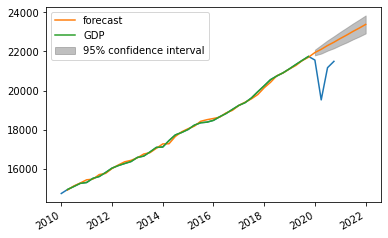

In [21]:
shock = '2020-01-01'
forecast(gdp, shock, begin='2010', p=1, d=1, q=1)

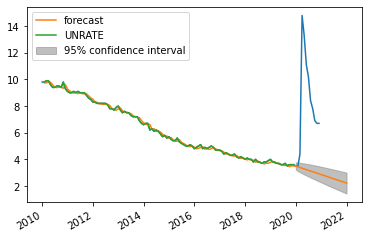

In [22]:
shock = '2020-01-01'
forecast(un, shock, begin='2010', p=2, d=1, q=1)

In [23]:
# 2. Is GDP a unit root process or trend stationary?

def test_stationarity(timeseries, window=12):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    return dfoutput

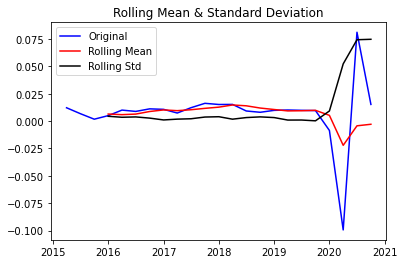

Results of Dickey-Fuller Test:


Test Statistic                 -0.205765
p-value                         0.937831
#Lags Used                      9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64

In [24]:
# 2020
df = gdp.iloc[gdp.index > '2015']
#df = df.iloc[df.index <= '2021']
df.index = pd.to_datetime(df.index)
df = np.log(df)
df = df - df.shift()
df.dropna(inplace = True)

test_stationarity(df, window=4)

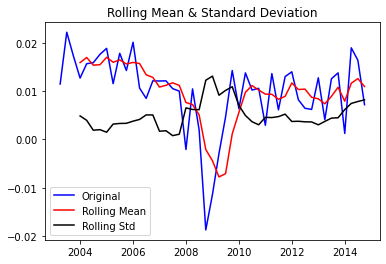

Results of Dickey-Fuller Test:


Test Statistic                 -3.781091
p-value                         0.003107
#Lags Used                      0.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64

In [25]:
# 2008
df = gdp.iloc[gdp.index > '2003']
df = df.iloc[df.index <= '2015']
df.index = pd.to_datetime(df.index)
df = np.log(df)
df = df - df.shift()
df.dropna(inplace = True)

test_stationarity(df, window=4)

In [26]:
# 2020: we don't know yet but based on the available data it looks like a unit root process
# 2008: is stationnary (p-value < 0.05)